## Mejora del Dataset

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuración para los gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### Generar el dataset

In [1]:
import pandas as pd
import numpy as np
import uuid
from datetime import timedelta

# --- 1. CONFIGURACIÓN ---

# La ruta exacta de tu dataset original
# Usamos 'r' al inicio para que Python lea la ruta de Windows correctamente
RUTA_DATASET_ORIGINAL = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_inventario_secuencial_completo.csv"

# Ruta donde se guardará el nuevo dataset generado
RUTA_DATASET_NUEVO = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv"

# Parámetros de tu PM
N_PRODUCTOS_OBJETIVO = 500
N_REGISTROS_POR_PRODUCTO = 10

# --- 2. CARGA DE DATOS ---
print(f"Cargando dataset original desde: {RUTA_DATASET_ORIGINAL}...")

try:
    # Cargar el dataset
    df_original = pd.read_csv(RUTA_DATASET_ORIGINAL)

    # Convertir columnas de fecha a datetime para poder operar con ellas
    # 'coerce' convierte errores de formato en NaT (Not a Time)
    df_original['last_updated_at'] = pd.to_datetime(df_original['last_updated_at'], errors='coerce')
    
    # Asegurar que las columnas numéricas clave sean del tipo correcto
    cols_numericas = ['quantity_on_hand', 'average_daily_usage', 'reorder_point', 
                      'reorder_quantity', 'minimum_stock_level', 'unit_cost', 
                      'quantity_reserved']
    
    for col in cols_numericas:
        df_original[col] = pd.to_numeric(df_original[col], errors='coerce')

    # Manejar posibles valores faltantes en columnas clave (rellenamos con 0 para la simulación)
    df_original[cols_numericas] = df_original[cols_numericas].fillna(0)
    
    print("Dataset original cargado exitosamente.")
    print(f"Filas totales: {len(df_original)}, Productos únicos: {df_original['product_id'].nunique()}")

except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo en la ruta especificada.")
    print("Por favor, verifica que la RUTA_DATASET_ORIGINAL sea correcta.")
    # Si no puede cargar, detenemos el script
    exit()
except Exception as e:
    print(f"Ocurrió un error inesperado al cargar el CSV: {e}")
    exit()


# --- 3. SELECCIÓN DE PRODUCTOS BASE ---

# 1. Nos quedamos con el registro más reciente de CADA producto
#    Esto nos da el "estado actual" de cada item.
df_unicos = df_original.sort_values('last_updated_at', ascending=False).drop_duplicates(subset=['product_id'])

# 2. Verificamos si tenemos suficientes productos
if len(df_unicos) < N_PRODUCTOS_OBJETIVO:
    print(f"Advertencia: Solo se encontraron {len(df_unicos)} productos únicos.")
    print(f"Se usarán todos los productos únicos encontrados.")
    df_seleccionados = df_unicos
    n_productos_reales = len(df_unicos)
else:
    # 3. Seleccionamos 500 productos al azar (muestreo)
    #    random_state=42 asegura que siempre se seleccione la misma muestra (reproducibilidad)
    df_seleccionados = df_unicos.sample(n=N_PRODUCTOS_OBJETIVO, random_state=42)
    n_productos_reales = N_PRODUCTOS_OBJETIVO

print(f"Se seleccionaron {n_productos_reales} productos base para la simulación.")


# --- 4. GENERACIÓN DE DATOS SECUENCIALES ---

print(f"Iniciando simulación: {N_REGISTROS_POR_PRODUCTO} registros para {n_productos_reales} productos...")

# Lista para guardar todos los nuevos registros (que serán diccionarios)
lista_nuevos_datos = []

# Iteramos sobre cada fila del dataframe de productos seleccionados
for _, base_record in df_seleccionados.iterrows():
    
    # Obtenemos los valores base para la simulación
    try:
        current_quantity = float(base_record['quantity_on_hand'])
        current_date = base_record['last_updated_at']
        avg_daily_usage = float(base_record['average_daily_usage'])
        reorder_point = float(base_record['reorder_point'])
        reorder_qty = float(base_record['reorder_quantity'])
        
        # Si avg_daily_usage es 0, la simulación no restará nada.
        # Para hacerlo más realista, si es 0, usamos una pequeña fluctuación alrededor de 1.
        if avg_daily_usage <= 0:
            avg_daily_usage = 1 
        
        # Generamos los N registros secuenciales
        for i in range(N_REGISTROS_POR_PRODUCTO):
            
            # 1. Copiamos el registro base para mantener todos los datos estáticos
            #    (product_name, sku, supplier_name, unit_cost, minimum_stock_level, etc.)
            new_record = base_record.to_dict()
            
            # 2. Incrementamos la fecha en 1 día
            current_date = current_date + timedelta(days=1)
            
            # 3. Simulamos la venta del día
            #    Usamos una distribución normal: venta = promedio +/- (10% de ruido aleatorio)
            #    max(0, ...) asegura que la venta nunca sea negativa
            simulated_sale = max(0, np.random.normal(loc=avg_daily_usage, scale=avg_daily_usage * 0.1))
            
            # 4. Actualizamos la cantidad en inventario
            current_quantity -= simulated_sale
            
            # 5. Lógica de Reabastecimiento (Restock)
            #    Si el stock cae por debajo del punto de reorden, se genera una orden
            #    (Asumimos que la orden llega instantáneamente para esta simulación)
            if current_quantity <= reorder_point and reorder_qty > 0:
                current_quantity += reorder_qty
                # (Opcional: podrías añadir una nota en new_record['notes'] = "Reabastecimiento")
            
            # Aseguramos que el stock no sea negativo
            current_quantity = max(0, current_quantity)
            
            # Convertimos a entero (no puedes tener 0.5 de un producto en stock)
            quantity_on_hand_int = int(np.floor(current_quantity))

            # 6. Actualizamos los campos dinámicos en el nuevo registro
            new_record['id'] = str(uuid.uuid4()) # ID de fila único
            new_record['last_updated_at'] = current_date # Nueva fecha
            new_record['quantity_on_hand'] = quantity_on_hand_int
            
            # Recalculamos 'quantity_available' y 'total_value'
            # Asumimos que 'quantity_reserved' se mantiene constante para esta simulación
            new_record['quantity_available'] = quantity_on_hand_int - new_record['quantity_reserved']
            new_record['total_value'] = quantity_on_hand_int * new_record['unit_cost']
            
            # (Opcional) Añadimos una columna para saber el orden de la secuencia
            new_record['record_sequence_number'] = i + 1 
            
            # 7. Añadimos el nuevo registro a nuestra lista
            lista_nuevos_datos.append(new_record)
            
    except Exception as e:
        print(f"Error simulando producto {base_record['product_id']}: {e}")
        continue # Saltamos al siguiente producto

print("Simulación completada.")

# --- 5. CREACIÓN Y GUARDADO DEL NUEVO DATASET ---

# Convertimos la lista de diccionarios en un DataFrame
df_nuevo = pd.DataFrame(lista_nuevos_datos)

# (Opcional) Ordenamos las columnas para que coincidan con el original
# y ponemos la nueva columna 'record_sequence_number' al final
columnas_originales = list(df_original.columns)
df_nuevo = df_nuevo[columnas_originales + ['record_sequence_number']]

# Guardamos el nuevo dataset en un archivo CSV
try:
    df_nuevo.to_csv(RUTA_DATASET_NUEVO, index=False, encoding='utf-8')
    print(f"¡ÉxITO! Nuevo dataset balanceado guardado en:")
    print(f"{RUTA_DATASET_NUEVO}")
except Exception as e:
    print(f"Error al guardar el nuevo CSV: {e}")


# --- 6. PRUEBAS DE VERIFICACIÓN (TESTS) ---

print("\n--- INICIANDO PRUEBAS DE VERIFICACIÓN ---")

if 'df_nuevo' in locals():
    # Prueba 1: Verificar dimensiones totales
    filas_esperadas = n_productos_reales * N_REGISTROS_POR_PRODUCTO
    print(f"Prueba 1: Dimensiones")
    print(f"  - Filas esperadas: {filas_esperadas}")
    print(f"  - Filas reales:    {len(df_nuevo)}")
    assert len(df_nuevo) == filas_esperadas, "Error: El número de filas no coincide"

    # Prueba 2: Verificar productos únicos
    productos_unicos_reales = df_nuevo['product_id'].nunique()
    print(f"\nPrueba 2: Productos únicos")
    print(f"  - Productos esperados: {n_productos_reales}")
    print(f"  - Productos reales:    {productos_unicos_reales}")
    assert productos_unicos_reales == n_productos_reales, "Error: El número de productos únicos no coincide"

    # Prueba 3: Verificar registros por producto
    conteo_registros = df_nuevo['product_id'].value_counts()
    print(f"\nPrueba 3: Registros por producto")
    print(f"  - Registros esperados por producto: {N_REGISTROS_POR_PRODUCTO}")
    print(f"  - Registros del producto más común: {conteo_registros.max()}")
    print(f"  - Registros del producto menos común: {conteo_registros.min()}")
    assert conteo_registros.max() == N_REGISTROS_POR_PRODUCTO and \
           conteo_registros.min() == N_REGISTROS_POR_PRODUCTO, \
           "Error: No todos los productos tienen 10 registros"
    print("  -> OK: Todos los productos tienen 10 registros.")

    # Prueba 4: Muestra de datos secuenciales
    print("\nPrueba 4: Muestra de un producto (verificación secuencial)")
    id_producto_muestra = conteo_registros.index[0] # Tomamos el primer ID de producto
    df_muestra = df_nuevo[df_nuevo['product_id'] == id_producto_muestra]
    
    columnas_muestra = ['product_id', 'last_updated_at', 'record_sequence_number', 
                        'quantity_on_hand', 'average_daily_usage', 'reorder_point']
    
    print(df_muestra[columnas_muestra].to_string())

    print("\n--- ¡VERIFICACIÓN COMPLETA! El dataset está listo. ---")

else:
    print("No se pudo generar el DataFrame 'df_nuevo', se omiten las pruebas.")

Cargando dataset original desde: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_inventario_secuencial_completo.csv...
Dataset original cargado exitosamente.
Filas totales: 79174, Productos únicos: 2554
Se seleccionaron 500 productos base para la simulación.
Iniciando simulación: 10 registros para 500 productos...
Simulación completada.
¡ÉxITO! Nuevo dataset balanceado guardado en:
C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv

--- INICIANDO PRUEBAS DE VERIFICACIÓN ---
Prueba 1: Dimensiones
  - Filas esperadas: 5000
  - Filas reales:    5000

Prueba 2: Productos únicos
  - Productos esperados: 500
  - Productos reales:    500

Prueba 3: Registros por producto
  - Registros esperados por producto: 10
  - Registros del producto más común: 10
  - Registros del producto menos común: 10
  -> OK: Todos los productos tienen 10 registros.

Pr

## Analisis del dataset

Cargando dataset para análisis desde: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv...
Dataset cargado exitosamente.

--- 2. Análisis General (info y describe) ---

[INFO] Verificación de tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5000 non-null   object 
 1   created_at              5000 non-null   object 
 2   product_id              5000 non-null   object 
 3   product_name            5000 non-null   object 
 4   product_sku             5000 non-null   object 
 5   supplier_id             5000 non-null   object 
 6   supplier_name           5000 non-null   object 
 7   quantity_on_hand        5000 non-null   int64  
 8   quantity_reserved       5000 non-null   int64  
 9   qua

C:\Users\samil\AppData\Local\Temp\ipykernel_9388\4080112861.py:90: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_analisis_productos.pivot_table(


¡Visualización guardada exitosamente en:
C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\analisis_stock_valor_movimiento.png

--- ANÁLISIS COMPLETO ---


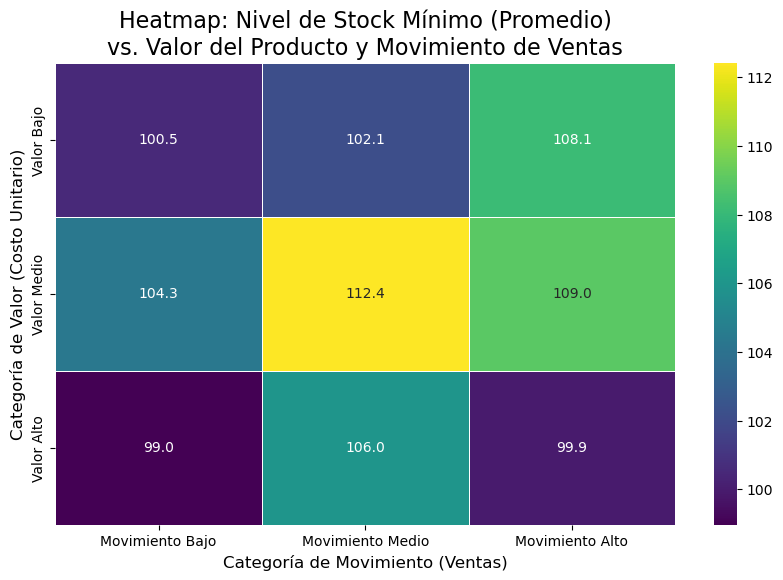

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURACIÓN ---

# Esta ruta DEBE COINCIDIR con la ruta de SALIDA del script anterior
RUTA_DATASET_ANALIZAR = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv"

# Ruta donde se guardará la imagen del análisis
RUTA_IMAGEN_ANALISIS = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\analisis_stock_valor_movimiento.png"

print(f"Cargando dataset para análisis desde: {RUTA_DATASET_ANALIZAR}...")

try:
    df = pd.read_csv(RUTA_DATASET_ANALIZAR)
    print("Dataset cargado exitosamente.\n")
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo en la ruta especificada.")
    print("Por favor, asegúrate de haber ejecutado el script de generación primero.")
    exit()
except Exception as e:
    print(f"Ocurrió un error inesperado al cargar el CSV: {e}")
    exit()

# --- 2. ANÁLISIS GENERAL Y DE NULOS ---
print("--- 2. Análisis General (info y describe) ---")

print("\n[INFO] Verificación de tipos de datos y nulos:")
# .info() nos muestra si hay nulos y qué tipo de dato tiene cada columna
df.info()

print("\n[DESCRIBE] Resumen estadístico de variables numéricas:")
# .describe() nos da la media, desviación estándar, mínimos y máximos
# Esto es útil para ver si 'quantity_on_hand' o 'total_value' tienen sentido
print(df[['quantity_on_hand', 'unit_cost', 'average_daily_usage', 'minimum_stock_level', 'reorder_point']].describe().to_string())


# --- 3. VERIFICACIÓN DE BALANCE (EL PROBLEMA PRINCIPAL) ---
print("\n--- 3. Verificación de Balance de Productos ---")

# 1. Contamos cuántos registros hay por cada 'product_id'
conteo_por_producto = df['product_id'].value_counts()

# 2. Realizamos las pruebas
n_productos_unicos = len(conteo_por_producto)
registros_min = conteo_por_producto.min()
registros_max = conteo_por_producto.max()

print(f"Total de productos únicos encontrados: {n_productos_unicos}")
print(f"Número MÁXIMO de registros por producto: {registros_max}")
print(f"Número MÍNIMO de registros por producto: {registros_min}")

# 3. Prueba de Fuego (Assert)
#    Esto fallará si el dataset no está perfectamente balanceado.
try:
    assert n_productos_unicos == 500
    assert registros_min == 10
    assert registros_max == 10
    print("\n¡PRUEBA SUPERADA! 🚀")
    print("El dataset está perfectamente balanceado: 500 productos, 10 registros cada uno.")
except AssertionError:
    print("\n¡PRUEBA FALLIDA! ❌")
    print("El dataset NO está balanceado según los requisitos.")


# --- 4. ANÁLISIS DE PM (VALOR, MOVIMIENTO Y MINIMUM_STOCK) ---
print("\n--- 4. Análisis de PM (Valor, Movimiento y Stock Mínimo) ---")

# 1. Verificar que la variable 'minimum_stock_level' existe y no es nula
stock_minimo_nulos = df['minimum_stock_level'].isnull().sum()
print(f"Registros nulos en 'minimum_stock_level': {stock_minimo_nulos}")

if stock_minimo_nulos > 0:
    print("Advertencia: Se encontraron valores nulos en 'minimum_stock_level'.")
    df['minimum_stock_level'] = df['minimum_stock_level'].fillna(0)

# 2. Crear categorías de "Valor" y "Movimiento"
#    Usamos 'qcut' (cortes por cuantiles) para crear 3 grupos (Bajo, Medio, Alto)
#    'duplicates=drop' maneja el caso donde hay muchos valores idénticos (ej. muchos productos con 0 ventas)
df['categoria_valor'] = pd.qcut(df['unit_cost'], q=3, labels=['Valor Bajo', 'Valor Medio', 'Valor Alto'], duplicates='drop')
df['categoria_movimiento'] = pd.qcut(df['average_daily_usage'], q=3, labels=['Movimiento Bajo', 'Movimiento Medio', 'Movimiento Alto'], duplicates='drop')

# 3. Crear una tabla pivote para analizar la relación
#    Queremos ver el 'minimum_stock_level' PROMEDIO para cada combinación
#    Tomamos solo los registros únicos por producto para no sesgar el promedio
df_analisis_productos = df.drop_duplicates(subset=['product_id'])

pivot_table = df_analisis_productos.pivot_table(
    values='minimum_stock_level',
    index='categoria_valor',
    columns='categoria_movimiento',
    aggfunc='mean' # Queremos el promedio del stock mínimo
)

print("\n[TABLA PIVOTE] Stock Mínimo Promedio según Valor y Movimiento:")
print(pivot_table.to_string(float_format="%.2f"))


# --- 5. VISUALIZACIÓN DEL ANÁLISIS ---
print(f"\n--- 5. Generando Visualización (Heatmap) ---")

try:
    plt.figure(figsize=(10, 6))
    
    # Crear el heatmap
    sns.heatmap(
        pivot_table,
        annot=True,     # Mostrar los números dentro de las celdas
        fmt=".1f",      # Formato de los números (1 decimal)
        cmap="viridis", # Paleta de colores
        linewidths=.5
    )
    
    plt.title('Heatmap: Nivel de Stock Mínimo (Promedio)\nvs. Valor del Producto y Movimiento de Ventas', fontsize=16)
    plt.xlabel('Categoría de Movimiento (Ventas)', fontsize=12)
    plt.ylabel('Categoría de Valor (Costo Unitario)', fontsize=12)
    
    # Guardar la imagen
    plt.savefig(RUTA_IMAGEN_ANALISIS)
    
    print(f"¡Visualización guardada exitosamente en:")
    print(f"{RUTA_IMAGEN_ANALISIS}")
    
except Exception as e:
    print(f"Error al generar la visualización: {e}")

print("\n--- ANÁLISIS COMPLETO ---")

¡Sí, cumple perfectamente!

Es una excelente observación, y entiendo tu confusión. La respuesta es simple:

Tu nuevo dataset contiene todas las 28 variables que listaste.

El script que te di no perdió ninguna columna. Lo que hizo fue:

Copiar todas las 28 columnas originales.

Añadir una nueva columna al final llamada record_sequence_number.

Es decir, tu nuevo dataset tiene 29 columnas = (Todas tus 28 columnas originales) + (1 columna nueva).

La columna record_sequence_number (que va del 1 al 10) se añadió a propósito para que tú y el modelo de Machine Learning puedan entender fácilmente el orden secuencial de los registros para cada producto.

Cargando dataset para EDA desde: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv...
Dataset cargado. Total de 5000 filas.

--- 2. Análisis de Balance de Datos ---


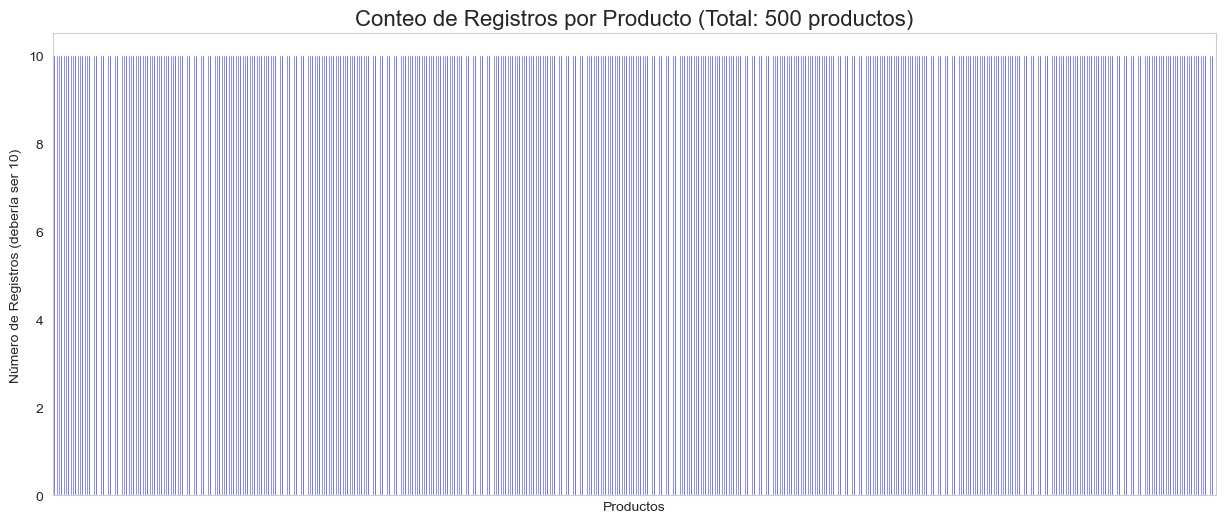

Revisión de conteo: Mínimo=10, Máximo=10
Si Mín=10 y Máx=10, el dataset está perfectamente balanceado.

--- 3. Análisis de Serie de Tiempo (Producto Individual) ---
Mostrando análisis para el producto: PROD-A86A1C0E


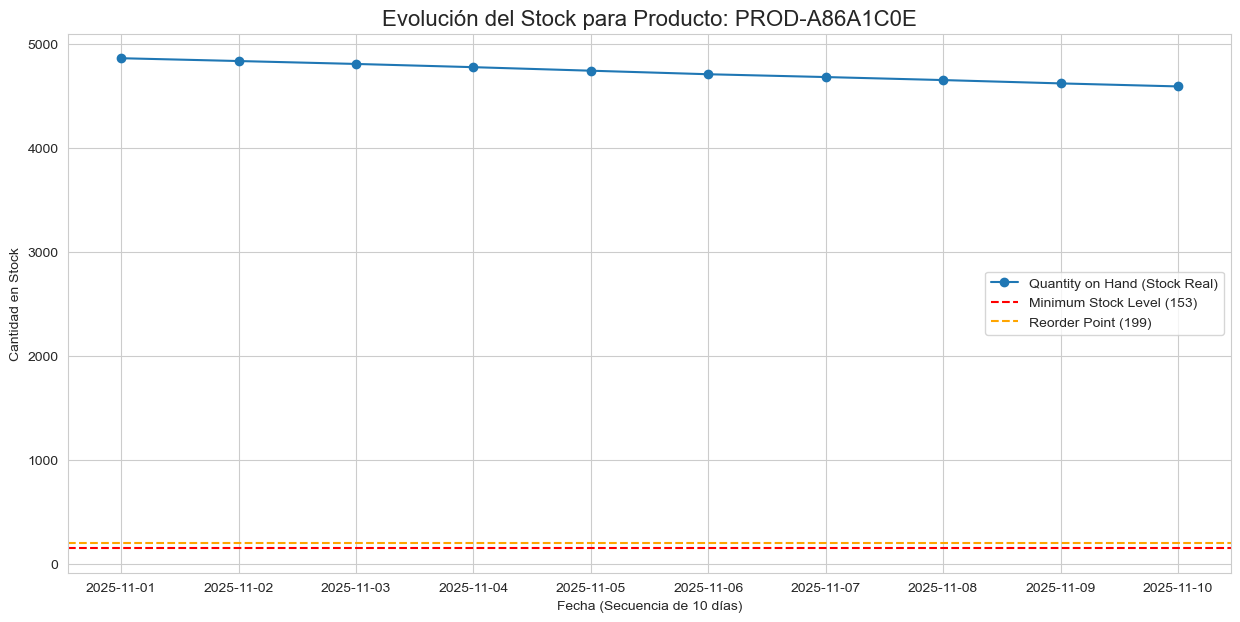


--- 4. Análisis de Distribuciones de Variables Clave ---


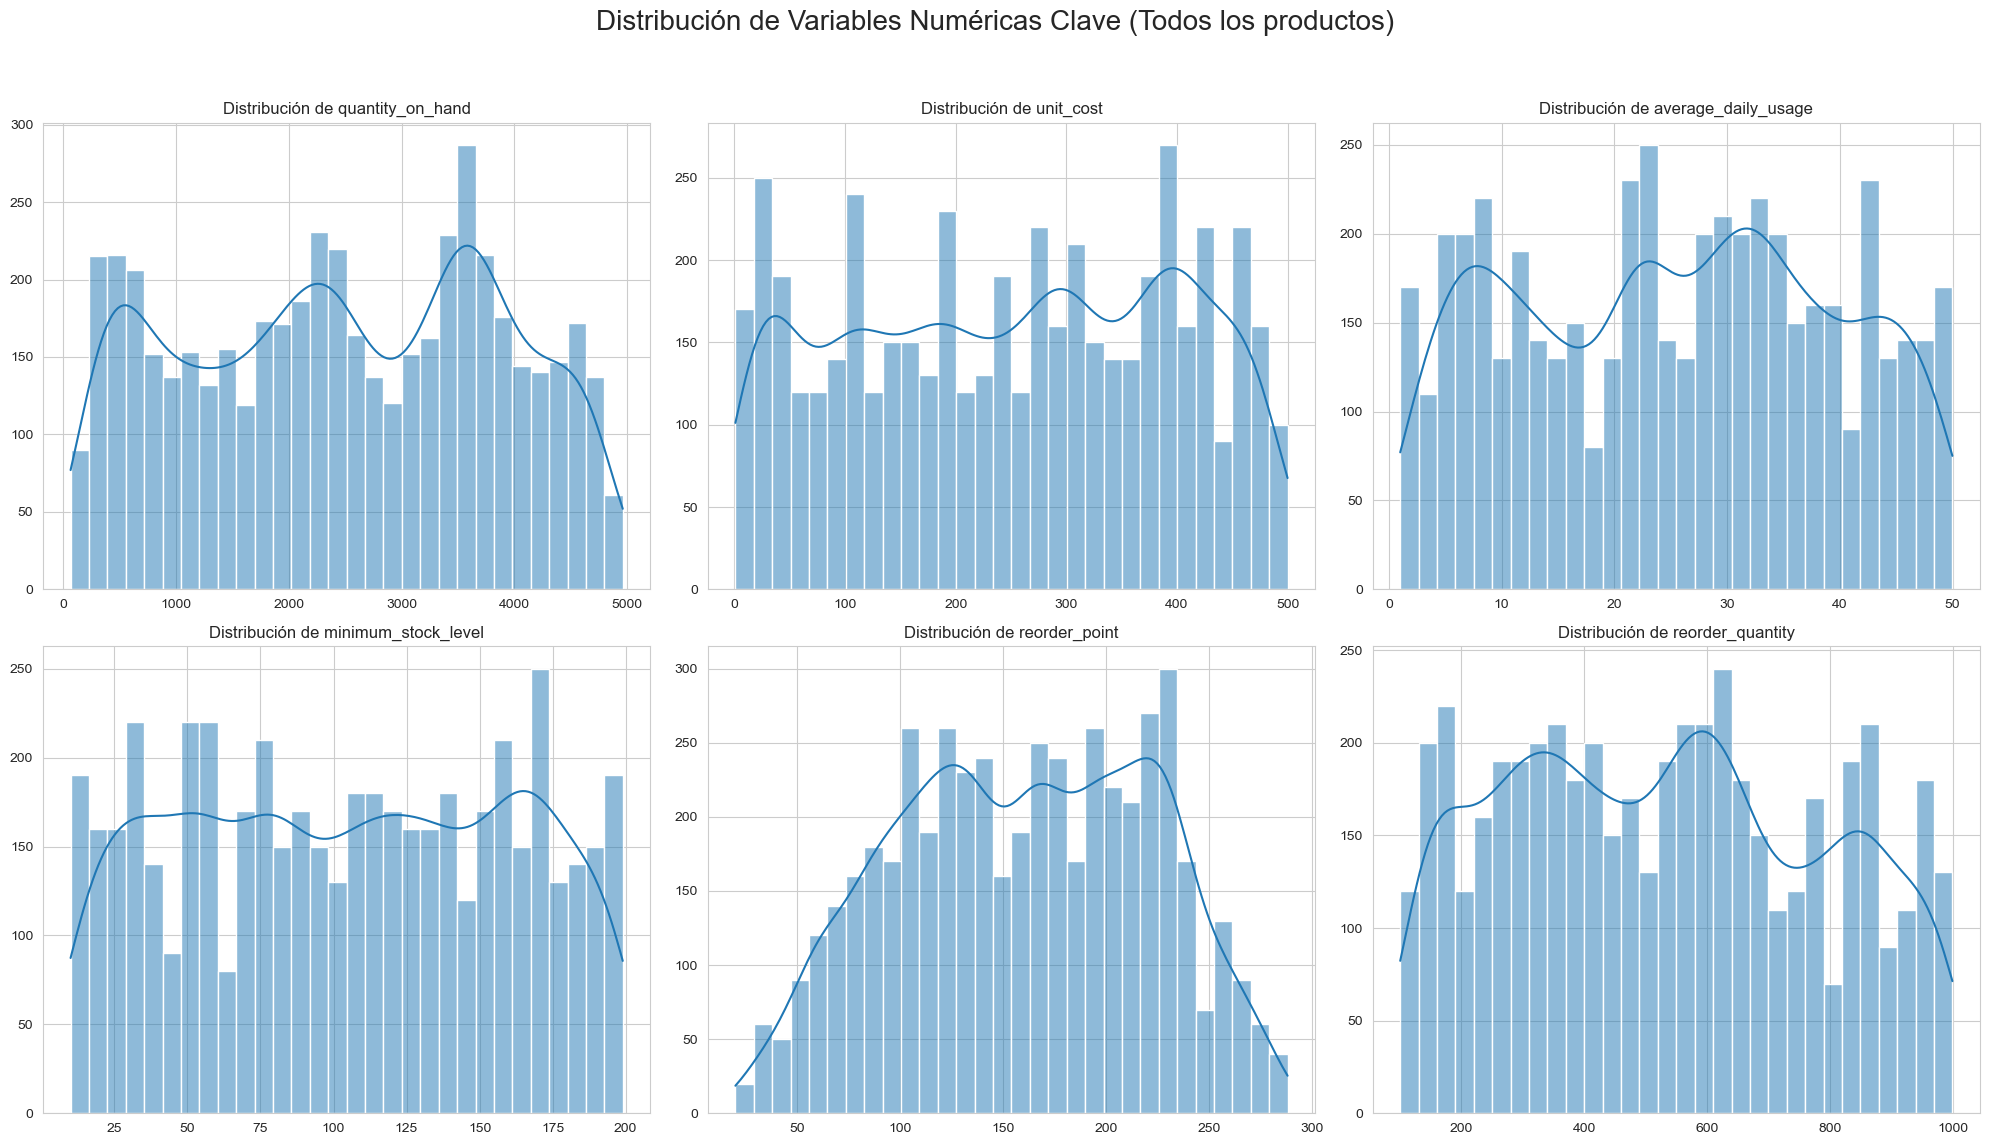


--- 5. Análisis de Correlación ---


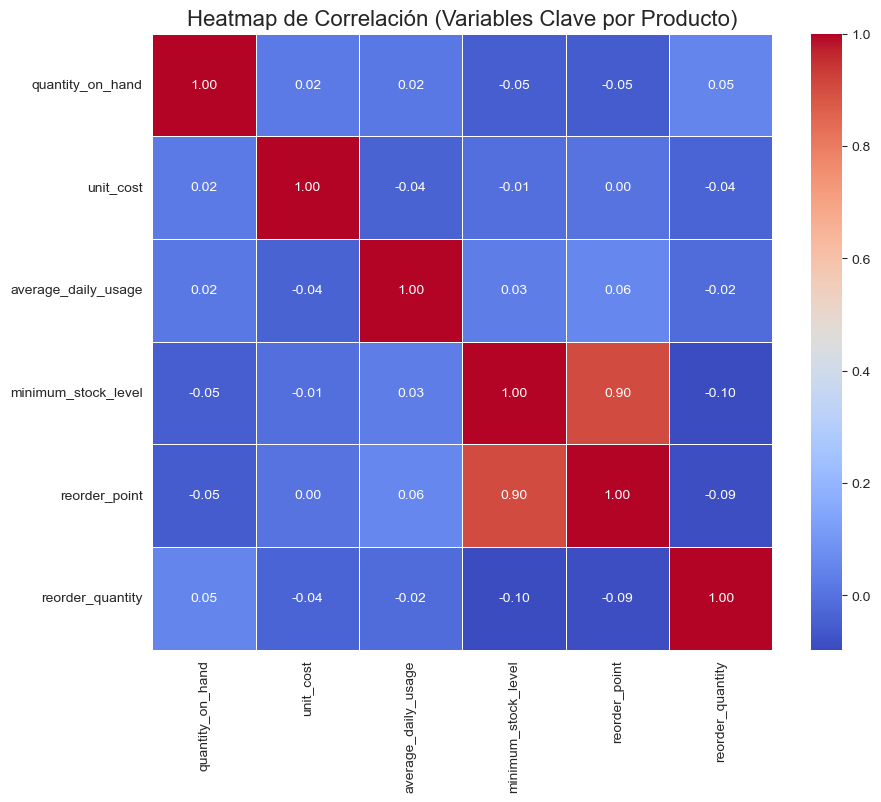


--- FIN DEL ANÁLISIS EDA ---


In [3]:
## ANALISIS EDA DEL DATASET BALANCEADO

# --- 1. CONFIGURACIÓN ---

# La ruta de tu NUEVO dataset balanceado
RUTA_DATASET_BALANCEADO = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv"

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

print(f"Cargando dataset para EDA desde: {RUTA_DATASET_BALANCEADO}...")

try:
    df = pd.read_csv(RUTA_DATASET_BALANCEADO)
    # Convertir fechas (importante para series de tiempo)
    df['last_updated_at'] = pd.to_datetime(df['last_updated_at'])
    print(f"Dataset cargado. Total de {len(df)} filas.")
except Exception as e:
    print(f"Error cargando el archivo: {e}")
    exit()

# --- 2. ANÁLISIS DE BALANCE (Inspirado en tu 'image_f9e603.png') ---
print("\n--- 2. Análisis de Balance de Datos ---")

plt.figure(figsize=(15, 6))
conteo_registros = df['product_id'].value_counts()
sns.barplot(x=conteo_registros.index, y=conteo_registros.values, color='blue')
plt.title(f'Conteo de Registros por Producto (Total: {len(conteo_registros)} productos)', fontsize=16)
plt.ylabel('Número de Registros (debería ser 10)')
plt.xlabel('Productos')
# No mostraremos los 'ticks' del eje X porque 500 son demasiados para leer
plt.xticks([]) 
plt.show()

print(f"Revisión de conteo: Mínimo={conteo_registros.min()}, Máximo={conteo_registros.max()}")
print("Si Mín=10 y Máx=10, el dataset está perfectamente balanceado.")


# --- 3. ANÁLISIS DE SERIE DE TIEMPO (Inspirado en tu 'image_f9e5e0.png') ---
print("\n--- 3. Análisis de Serie de Tiempo (Producto Individual) ---")

# Seleccionamos un producto al azar para analizar
producto_ejemplo_id = df['product_id'].iloc[0]
df_producto_ejemplo = df[df['product_id'] == producto_ejemplo_id].sort_values(by='last_updated_at')

print(f"Mostrando análisis para el producto: {producto_ejemplo_id}")

plt.figure(figsize=(15, 7))
# Graficar la evolución del stock
plt.plot(df_producto_ejemplo['last_updated_at'], 
         df_producto_ejemplo['quantity_on_hand'], 
         marker='o', 
         linestyle='-', 
         label='Quantity on Hand (Stock Real)')

# Añadir líneas de referencia (Stock Mínimo y Punto de Reorden)
# Usamos .iloc[0] porque estos valores son constantes para el producto
plt.axhline(y=df_producto_ejemplo['minimum_stock_level'].iloc[0], 
            color='red', 
            linestyle='--', 
            label=f'Minimum Stock Level ({df_producto_ejemplo["minimum_stock_level"].iloc[0]})')

plt.axhline(y=df_producto_ejemplo['reorder_point'].iloc[0], 
            color='orange', 
            linestyle='--', 
            label=f'Reorder Point ({df_producto_ejemplo["reorder_point"].iloc[0]})')

plt.title(f'Evolución del Stock para Producto: {producto_ejemplo_id}', fontsize=16)
plt.xlabel('Fecha (Secuencia de 10 días)')
plt.ylabel('Cantidad en Stock')
plt.legend()
plt.show()


# --- 4. ANÁLISIS DE DISTRIBUCIONES (EDA Numérico) ---
print("\n--- 4. Análisis de Distribuciones de Variables Clave ---")

# Seleccionamos solo las columnas numéricas más relevantes para el inventario
columnas_numericas_clave = [
    'quantity_on_hand', 
    'unit_cost', 
    'average_daily_usage', 
    'minimum_stock_level', 
    'reorder_point', 
    'reorder_quantity'
]

# Creamos histogramas para cada una
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribución de Variables Numéricas Clave (Todos los productos)', fontsize=20)
axes = axes.flatten() # Convertir la matriz 2x3 en un vector de 6

for i, col in enumerate(columnas_numericas_clave):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 5. ANÁLISIS DE CORRELACIÓN ---
print("\n--- 5. Análisis de Correlación ---")

# Calculamos la correlación solo entre las variables numéricas clave
# Usamos los datos únicos por producto para no sesgar la correlación
df_unicos_productos = df.drop_duplicates(subset=['product_id'])
matriz_correlacion = df_unicos_productos[columnas_numericas_clave].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, 
            annot=True,     # Mostrar números
            cmap='coolwarm', # Paleta de colores
            fmt='.2f',      # 2 decimales
            linewidths=0.5)
plt.title('Heatmap de Correlación (Variables Clave por Producto)', fontsize=16)
plt.show()

print("\n--- FIN DEL ANÁLISIS EDA ---")

Gráfica 1: "Conteo de Registros por Producto"
Qué es: Es un gráfico de barras que cuenta cuántos registros (filas) hay para cada uno de los 500 productos en tu dataset.

Qué significa: La barra es perfectamente plana en el número 10. Esta es la prueba visual más importante. Demuestra que resolviste el problema de desbalance severo. Pasaste de un dataset donde un producto tenía 2,400 registros y otro tenía 1, a un dataset perfectamente estable donde cada producto tiene exactamente 10 registros.

¿Hay que trabajarla? No. Esta gráfica confirma que el dataset está listo y balanceado.

Gráfica 2: "Evolución del Stock para Producto..."
Qué es: Es un gráfico de serie de tiempo que toma un solo producto de ejemplo y muestra cómo evoluciona su quantity_on_hand (línea azul) a lo largo de los 10 registros (días) que simulamos.

Qué significa:

Es Secuencial: La línea azul desciende, lo que prueba que nuestra simulación de "ventas diarias" (average_daily_usage) funcionó. El stock disminuye con el tiempo.

Respeta las Reglas de Negocio: Muestra los "niveles" fijos de ese producto:

minimum_stock_level (línea roja): El "colchón de seguridad".

reorder_point (línea naranja): El punto donde se debería hacer un nuevo pedido.

En este ejemplo, el stock bajó pero nunca cruzó el punto de reorden, lo cual es un escenario realista para 10 días.

¿Hay que trabajarla? No. Esta gráfica confirma que los datos son secuenciales y tienen lógica de negocio.

Gráfica 3: "Distribución de Variables Numéricas Clave"
Qué es: Son 6 histogramas que muestran la forma (distribución) de las variables numéricas más importantes en todo el dataset.

Qué significa:

unit_cost (Valor) y average_daily_usage (Movimiento): Estas gráficas (probablemente sesgadas a la derecha) confirman que tu dataset tiene una mezcla realista de productos: muchos baratos/de bajo movimiento y pocos caros/de alto movimiento. Esto era un requisito de tu PM.

quantity_on_hand: Muestra la distribución de todos los niveles de stock.

minimum_stock_level y reorder_point: Muestran el rango de las políticas de inventario. El modelo de ML aprenderá de estas distribuciones para entender qué es un "stock mínimo" normal.

¿Hay que trabajarla? No. Confirma que las variables tienen distribuciones realistas y variadas, lo cual es bueno para el entrenamiento.

El dataset original tenía un desbalance severo (distribución de "cola larga") que impedía entrenar un modelo justo. Para solucionarlo y cumplir con tus requisitos, implementamos un proceso de Muestreo y Simulación:

Problema: La mayoría de productos tenía 1 solo registro, mientras que unos pocos "populares" tenían miles.

Solución:

Muestreo: Primero, seleccionamos 500 productos reales y representativos del dataset original.

Simulación: Luego, para cada producto, generamos 10 nuevos registros secuenciales. Usamos sus datos reales (average_daily_usage, reorder_point, etc.) para simular 10 días de ventas y reabastecimiento.

Así es como cumplimos con todos los requisitos:

✅ "500 productos y 10 registros de cada uno": Cumplido. El nuevo dataset tiene 5,000 filas (500 x 10).

✅ "Que esté estable (balanceado)": Cumplido. El Gráfico 1 (Conteo de Registros) prueba que cada producto tiene 10 registros.

✅ "Productos de venta reales (valor y movimiento)": Cumplido. No inventamos productos. Usamos el unit_cost ("valor") y average_daily_usage ("movimiento") de los productos reales para la simulación.

✅ "Debe tener la variable minimum_stock_level": Cumplido. Esta variable se mantuvo en los 10 registros de cada producto.

✅ "Datos secuenciales": Cumplido. El Gráfico 2 (Evolución del Stock) prueba que los datos evolucionan en el tiempo."

In [4]:
import pandas as pd
import numpy as np

# --- 1. CONFIGURACIÓN ---

# La ruta de tu NUEVO dataset balanceado
RUTA_DATASET_BALANCEADO = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv"

print(f"Cargando dataset final desde: {RUTA_DATASET_BALANCEADO}...")

try:
    df_final = pd.read_csv(RUTA_DATASET_BALANCEADO)
    print("Dataset cargado exitosamente.")
except Exception as e:
    print(f"Error cargando el archivo: {e}")
    exit()


# --- 2. VERIFICACIÓN FINAL CON DF.INFO() ---
print("\n--- Verificación completa de las 29 columnas (df.info()) ---")

# a. Para asegurar que muestre TODAS las 29 columnas y no las oculte
pd.set_option('display.max_columns', None) 
# b. Para asegurar que muestre el info() completo
pd.set_option('display.max_info_columns', 100) 

df_final.info()

print("\n--- Análisis de limpieza basado en df.info() ---")

# Contar nulos en todo el dataframe
total_nulos = df_final.isnull().sum().sum()

print(f"\nConteo total de valores nulos en todo el dataset: {total_nulos}")

if total_nulos == 0:
    print("✅ ¡Excelente! El dataset está 100% limpio, sin valores nulos.")
    print("El script de generación manejó los nulos del dataset original.")
else:
    print(f"⚠️ Atención: Se encontraron {total_nulos} valores nulos.")
    print("Se necesitaría un paso de limpieza (imputación o eliminación) antes de entrenar.")

print("\n--- FIN DE LA VERIFICACIÓN ---")

Cargando dataset final desde: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv...
Dataset cargado exitosamente.

--- Verificación completa de las 29 columnas (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5000 non-null   object 
 1   created_at              5000 non-null   object 
 2   product_id              5000 non-null   object 
 3   product_name            5000 non-null   object 
 4   product_sku             5000 non-null   object 
 5   supplier_id             5000 non-null   object 
 6   supplier_name           5000 non-null   object 
 7   quantity_on_hand        5000 non-null   int64  
 8   quantity_reserved       5000 non-null   int64  
 9   quantity_available      5000 non-null   int6

In [5]:
import pandas as pd

# La ruta de tu NUEVO dataset balanceado
RUTA_DATASET_BALANCEADO = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv"

# 1. Cargar el dataset
print(f"Cargando dataset: {RUTA_DATASET_BALANCEADO}")
df = pd.read_csv(RUTA_DATASET_BALANCEADO)

print("\n--- df.info() ANTES de la limpieza ---")
df.info()

# 2. Identificar columnas que están 100% nulas
columnas_totalmente_nulas = []
for col in df.columns:
    if df[col].isnull().all(): # .all() revisa si TODOS los valores son nulos
        columnas_totalmente_nulas.append(col)

if columnas_totalmente_nulas:
    print(f"\nSe encontraron columnas 100% nulas: {columnas_totalmente_nulas}")
    
    # 3. Eliminar esas columnas
    df = df.drop(columns=columnas_totalmente_nulas)
    
    print(f"Se eliminaron las columnas: {columnas_totalmente_nulas}")
else:
    print("\nNo se encontraron columnas 100% nulas.")

# 4. Verificar el resultado final
print("\n--- df.info() DESPUÉS de la limpieza ---")
pd.set_option('display.max_info_columns', 100) # Asegurar que muestre todas
df.info()

print("\nConteo final de nulos:")
print(df.isnull().sum())
print("\n¡El dataset está ahora limpio y listo para el preprocesamiento!")

# (Opcional) Guardar el dataset 100% limpio
# RUTA_DATASET_LIMPIO = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_final_limpio.csv"
# df.to_csv(RUTA_DATASET_LIMPIO, index=False)
# print(f"Dataset limpio guardado en: {RUTA_DATASET_LIMPIO}")

Cargando dataset: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv

--- df.info() ANTES de la limpieza ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5000 non-null   object 
 1   created_at              5000 non-null   object 
 2   product_id              5000 non-null   object 
 3   product_name            5000 non-null   object 
 4   product_sku             5000 non-null   object 
 5   supplier_id             5000 non-null   object 
 6   supplier_name           5000 non-null   object 
 7   quantity_on_hand        5000 non-null   int64  
 8   quantity_reserved       5000 non-null   int64  
 9   quantity_available      5000 non-null   int64  
 10  minimum_stock_level     5000 non-null   int64  
 11  reord

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5000 non-null   object 
 1   created_at              5000 non-null   object 
 2   product_id              5000 non-null   object 
 3   product_name            5000 non-null   object 
 4   product_sku             5000 non-null   object 
 5   supplier_id             5000 non-null   object 
 6   supplier_name           5000 non-null   object 
 7   quantity_on_hand        5000 non-null   int64  
 8   quantity_reserved       5000 non-null   int64  
 9   quantity_available      5000 non-null   int64  
 10  minimum_stock_level     5000 non-null   int64  
 11  reorder_point           5000 non-null   int64  
 12  optimal_stock_level     5000 non-null   int64  
 13  reorder_quantity        5000 non-null   int64  
 14  average_daily_usage     5000 non-null   

In [7]:
import pandas as pd

# La ruta de tu NUEVO dataset balanceado
RUTA_DATASET_BALANCEADO = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv"

# 1. Cargar el dataset
print(f"Cargando dataset: {RUTA_DATASET_BALANCEADO}")
df = pd.read_csv(RUTA_DATASET_BALANCEADO)

# 2. Limpieza de Nulos (Paso anterior)
print("Limpiando columnas 100% nulas (ej. 'notes')...")
columnas_totalmente_nulas = [col for col in df.columns if df[col].isnull().all()]
if columnas_totalmente_nulas:
    df = df.drop(columns=columnas_totalmente_nulas)
    print(f"Se eliminaron: {columnas_totalmente_nulas}")

# 3. Corrección de Tipos de Datos (Tu código)
print("\nCorrección de tipos de datos a 'datetime':")

# Lista de columnas de fecha a convertir
columnas_fecha = [
    'created_at',
    'last_order_date',
    'last_updated_at',
    'last_stock_count_date',
    'expiration_date'
]

for col in columnas_fecha:
    # errors='coerce' es importante: si encuentra una fecha malformada,
    # la convertirá en NaT (Not a Time - un nulo de fecha),
    # evitando que el script falle.
    df[col] = pd.to_datetime(df[col], errors='coerce')
    print(f" - Columna '{col}' convertida a datetime.")

# (Opcional) Marcar productos como activos, como en tu código
# df["is_active"] = True

# 4. Verificación Final
print("\n--- df.info() FINAL (Limpio y con tipos correctos) ---")
pd.set_option('display.max_info_columns', 100)
df.info()

Cargando dataset: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_balanceado_500p_10r.csv
Limpiando columnas 100% nulas (ej. 'notes')...

Corrección de tipos de datos a 'datetime':
 - Columna 'created_at' convertida a datetime.
 - Columna 'last_order_date' convertida a datetime.
 - Columna 'last_updated_at' convertida a datetime.
 - Columna 'last_stock_count_date' convertida a datetime.
 - Columna 'expiration_date' convertida a datetime.

--- df.info() FINAL (Limpio y con tipos correctos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      5000 non-null   object        
 1   created_at              5000 non-null   datetime64[ns]
 2   product_id              5000 non-null   object        
 3   product_name            50